In [2]:
import os
import h5py
import numpy as np
import keras
from keras import Input, Model
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Activation, Dropout
from keras.optimizers import Adam
import tensorflow as tf

Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [3]:
test_input = np.load('testInput.npy', allow_pickle=True)
test_output = np.load('testOutput.npy', allow_pickle=True)

In [4]:
train_input = np.load('trainInput.npy', allow_pickle=True)

In [5]:
train_output = np.load('trainOutput.npy', allow_pickle=True)
valid_input = np.load('validInput.npy', allow_pickle=True)
valid_output = np.load('validOutput.npy', allow_pickle=True)

In [6]:
test_input = np.concatenate(test_input, axis=0)
train_input = np.squeeze(np.concatenate(train_input[:250], axis=0))
valid_input = np.concatenate(valid_input, axis=0)
test_output = np.squeeze(np.concatenate(test_output, axis=0))
train_output = np.squeeze(np.concatenate(train_output[:250], axis=0))
valid_output = np.squeeze(np.concatenate(valid_output, axis=0))

In [7]:
print(test_input.shape)
print(train_input.shape)
print(train_output.shape)
print(valid_input.shape)
print(valid_output.shape)

(651946, 1000, 4)
(2048000, 1000, 4)
(2048000, 4)
(494358, 1000, 4)
(494358, 4)


In [24]:
p = np.random.permutation(100000)
small_train_input = train_input[:100000][p]
small_train_output = train_output[:100000][p]
small_valid_input = valid_input[:30000]
small_valid_output = valid_output[:30000]

In [25]:
# params = {'leftpos': 9500, 'rightpos':10500,
#           'numconvlayers': {'numFiltersConv1': 128, 'numFiltersConv2': 32,  'filterLenConv1':6, 'filterLenConv2': 9},
#          'dilRate1': 1,
#          'maxPool1': 30, 'dilRate2': 1, 'maxPool2': 10,
#          'numdenselayers': {'dense1': 64, 'dense2': 2, 'dropout1':0.00099, 'dropout2':0.01546},
#          'activationFxn': 'sigmoid',
#          'batch_size': 128}
params = {'leftpos': 9500, 'rightpos':10500,
          'numconvlayers': {'numFiltersConv1': 128, 'numFiltersConv2': 32,  'filterLenConv1':6, 'filterLenConv2': 9},
         'dilRate1': 1,
         'maxPool1': 30, 'dilRate2': 1, 'maxPool2': 10,
         'numdenselayers': {'dense1': 64, 'dense2': 16, 'dropout1':0.00099, 'dropout2':0.01546},
         'activationFxn': 'relu',
         'batch_size': 128}

In [26]:
# leftpos = int(params['leftpos'])
# rightpos = int(params['rightpos'])
# X_trainpromoterSubseq = X_trainpromoter[:,leftpos:rightpos,:]
# X_validpromoterSubseq = X_validpromoter[:,leftpos:rightpos,:]
# input_promoter = Input(shape=X_trainpromoterSubseq.shape[1:], name='promoter')

input_promoter = Input(shape=train_input.shape[1:], name='promoter')

x = Conv1D(int(params['numconvlayers']['numFiltersConv1']), int(params['numconvlayers']['filterLenConv1']), dilation_rate=int(params['dilRate1']), padding='same', kernel_initializer='glorot_normal', input_shape=train_input.shape[1:],activation=params['activationFxn'])(input_promoter)
x = MaxPooling1D(int(params['maxPool1']))(x)
x = Conv1D(int(params['numconvlayers']['numFiltersConv2']), int(params['numconvlayers']['filterLenConv2']), dilation_rate=int(params['dilRate2']), padding='same', kernel_initializer='glorot_normal',activation=params['activationFxn'])(x)
x = MaxPooling1D(params['maxPool2'])(x)
x = Flatten()(x)
x = Dense(int(params['numdenselayers']['dense1']))(x)
x = Activation(params['activationFxn'])(x)
x = Dropout(params['numdenselayers']['dropout1'])(x)
x = Dense(int(params['numdenselayers']['dense2']))(x)
x = Activation(params['activationFxn'])(x)
x = Dropout(params['numdenselayers']['dropout2'])(x)
main_output = Dense(4)(x)
#main_output = Activation('relu')(x) # force outputs to be at least 0
model = Model(inputs=[input_promoter], outputs=[main_output])
model.compile(Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),'mean_squared_error', metrics=['mean_squared_error'])
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
promoter (InputLayer)        (None, 1000, 4)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1000, 128)         3200      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 33, 128)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 33, 32)            36896     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 3, 32)             0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 96)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                6208

In [46]:
small_train_input = np.zeros([30000, 1000, 4])
small_train_output = np.zeros([30000, 4])

i = 0
for row in small_train_input:
    row[:, i % 4]=1
    small_train_output[i,i%4] = 100
    i+=1


model.fit(x=small_train_input, y=small_train_output,epochs=5, shuffle='batch',
          batch_size=params['batch_size'])#--, validation_data=(small_valid_input, small_valid_output))
model.save('model.h5')

Epoch 1/5
30000/30000 [==============================] - 20s 671us/step - loss: 1653.0044 - mean_squared_error: 1653.0051
Epoch 2/5
30000/30000 [==============================] - 20s 669us/step - loss: 292.5965 - mean_squared_error: 292.5966
Epoch 3/5
30000/30000 [==============================] - 20s 670us/step - loss: 33.7583 - mean_squared_error: 33.7583
Epoch 4/5
30000/30000 [==============================] - 20s 668us/step - loss: 32.1186 - mean_squared_error: 32.1186
Epoch 5/5
30000/30000 [==============================] - 20s 671us/step - loss: 25.4065 - mean_squared_error: 25.4065


In [47]:
print(model.predict(small_train_input[:10]))
print(small_train_output[:10])

[[ 9.8737373e+01  6.9886070e-01  3.2447100e-01  3.0264664e-01]
 [-4.6520859e-02  9.9102211e+01  2.3546650e-01 -1.0875416e-01]
 [ 3.4765276e-01 -1.6391309e-01  9.9103813e+01 -5.8114624e-01]
 [ 2.9192767e-01  1.6385771e-01  8.0017918e-01  9.8911987e+01]
 [ 9.8737373e+01  6.9886070e-01  3.2447100e-01  3.0264664e-01]
 [-4.6520859e-02  9.9102211e+01  2.3546650e-01 -1.0875416e-01]
 [ 3.4765276e-01 -1.6391309e-01  9.9103813e+01 -5.8114624e-01]
 [ 2.9192767e-01  1.6385771e-01  8.0017918e-01  9.8911987e+01]
 [ 9.8737373e+01  6.9886070e-01  3.2447100e-01  3.0264664e-01]
 [-4.6520859e-02  9.9102211e+01  2.3546650e-01 -1.0875416e-01]]
[[100.   0.   0.   0.]
 [  0. 100.   0.   0.]
 [  0.   0. 100.   0.]
 [  0.   0.   0. 100.]
 [100.   0.   0.   0.]
 [  0. 100.   0.   0.]
 [  0.   0. 100.   0.]
 [  0.   0.   0. 100.]
 [100.   0.   0.   0.]
 [  0. 100.   0.   0.]]


In [28]:
model = keras.models.load_model('model.h5')

In [29]:
print(test_output.shape)
print(np.unravel_index(np.argmax(test_output, axis=None), test_output.shape))

(651946, 4)
(365757, 0)


In [41]:
t = test_input[365757:365757+15]
t.shape
print(model.predict(t))
print(test_output[365757:365757+15])

[[53.363426   55.08339    47.36892    30.943857  ]
 [ 0.26755893  0.4030537   0.43565863  0.16318989]
 [ 0.3562812   0.373475    0.4093913   0.15952021]
 [ 0.28578314  0.38399857  0.42313838  0.1704999 ]
 [ 0.3307998   0.37213305  0.407654    0.15618595]
 [ 0.35184276  0.35690603  0.39983487  0.16445027]
 [ 0.3805746   0.3708354   0.40893197  0.16621205]
 [ 0.39659786  0.3838286   0.41518098  0.16263694]
 [ 0.48573336  0.4561138   0.44445926  0.10423741]
 [ 0.37649885  0.40481764  0.43076068  0.16334304]
 [ 0.34328905  0.40875128  0.42684883  0.14470622]
 [16.645351   13.637745   13.481875    7.8568974 ]
 [ 0.28867975  0.40997913  0.41499406  0.07785214]
 [ 0.38165122  0.3708537   0.4005987   0.1415399 ]
 [ 0.3357048   0.38272446  0.41983202  0.16435164]]
[[4.4325e+02 4.3425e+02 3.9925e+02 4.0350e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 2.2815e-01]
 [5.0018e-02 0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 3.9697e-01 4.2773e-01 0.0000e+00]
 [1.2225e-01 0.0000e+00 0.0000e+00 0.0000e+00]

In [32]:
import matplotlib.pyplot as plt

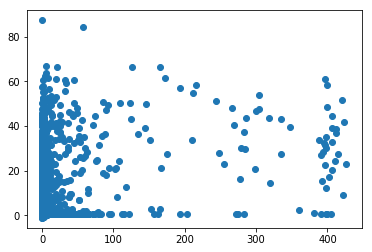

In [39]:
plt.scatter(test_output[:100000,2], model.predict(test_input[:100000])[:,2])
plt.show()

In [ ]:
output_class = 2 # the index of the output class we want to maximize
output = model.layers[-1].output
target = tf.math.scalar_mul(2, output[:,output_class])
m = tf.math.reduce_mean(output, axis=1)
loss = m - target
grads = tf.gradients(loss, model.input)[0] # the output of `gradients` is a list, just take the first (and only) element
iterate = keras.backend.function([model.input], [loss, grads])

In [ ]:
def generate_seq():
    def adam_update(grad, i, w):
        #initialize the values of the parameters
        alpha = 1
        beta_1 = 0.9
        beta_2 = 0.999 
        epsilon = 1e-8

        nonlocal theta_0
        nonlocal m
        nonlocal v 

        m = beta_1 * m + (1 - beta_1) * grad
        v = beta_2 * v + (1 - beta_2) * np.power(grad, 2)
        m_hat = m / (1 - np.power(beta_1, i))
        v_hat = v / (1 - np.power(beta_2, i))
        w = w + alpha * m_hat / (np.sqrt(v_hat) + epsilon)
        return w

    theta_0 = 0
    m = 0 
    v = 0 
    
    raw_input_seq = np.random.random((1, 1000, 4)) # define an initial random image

    lr = 1.  # learning rate used for gradient updates
    max_iter = 1000  # number of gradient updates iterations
    for i in range(max_iter):
        loss_val, grads_val = iterate([raw_input_seq])
        #print(grads_val)
        raw_input_seq = adam_update(grads_val, i+1, raw_input_seq)
        
        #raw_input_seq += grads_val * lr  # update the image based on gradients
        if i % 100 == 0:
            pred = model.predict(raw_input_seq)
            print('Iteration ' + str(i) + ': model activation ' + str(pred))
    
    # Convert back to one-hot encoding
    raw_input_seq = np.squeeze(raw_input_seq)
    max_activations = np.argmax(raw_input_seq, axis=1).flatten()
    encoded_seq = np.zeros(raw_input_seq.shape)
    encoded_seq[np.arange(encoded_seq.shape[0]), max_activations] = 1
    
    return raw_input_seq, encoded_seq



In [ ]:
for i in range(2):
    input_seq, encoded_seq = generate_seq()
    print(input_seq[:10,])
    print(encoded_seq[:10,])